# Routing shortest path on road networks

In [ ]:
from typing import List,Tuple, TypeAlias
from dataclasses import dataclass
import osmnx as ox
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation

## Parameters

In [ ]:
PLACE = "Palo Alto, California, USA"  
#PLACE= "San Pedro Sula, Cortés, Honduras"
POP_SIZE = 30
MAX_GEN = 50
MUT_RATE = 0.3
TOUR_SIZE = 3
MAX_WAYPOINTS = 5  # number of intermediate waypoints

## Downloading map & modeling Dijkstra a baseline

In [3]:
print("Downloading map...")
G = ox.graph_from_place(PLACE, network_type="drive")

# Pick random start and end nodes
# Use the largest strongly connected component if directed
if nx.is_directed(G):
    G_sub = G.subgraph(max(nx.strongly_connected_components(G), key=len)).copy()
else:
    G_sub = G.subgraph(max(nx.connected_components(G), key=len)).copy()

# Pick start/end from this connected component
nodes = list(G_sub.nodes)
start, end = random.sample(nodes, 2)
print("Start:", start, "End:", end)
# Baseline: Dijkstra shortest path
dijkstra_path = nx.shortest_path(G, start, end, weight="length")
dijkstra_len = nx.shortest_path_length(G, start, end, weight="length")
print("Dijkstra length:", dijkstra_len)


Start: 3707648848 End: 65581470
Dijkstra length: 8644.061053807005


## Types & Helpers 

In [11]:
Chromosome: TypeAlias = List[int]
Population: TypeAlias = List[Chromosome]

@dataclass
class GAResult:
    best_chromosome: Chromosome
    best_fitness: float
    best_paths_per_gen: List[List[int]]
    best_per_gen: List[float]
    mean_per_gen: List[float]

In [ ]:
all_shortest_paths = dict(nx.all_pairs_dijkstra_path(G_sub, weight='length'))
all_lengths = dict(nx.all_pairs_dijkstra_path_length(G_sub, weight='length'))

def path_length(path):
    """Return total length of a valid path."""
    try:
        #return sum(G[u][v][0]['length'] for u, v in zip(path[:-1], path[1:]))
        return sum(all_lengths[u][v] for u, v in zip(path[:-1], path[1:]))
    except Exception:
        return 1e6  # penalty if invalid

def build_full_path(waypoints):
    full_path = [start]
    nodes_sequence = [start] + waypoints + [end]
    for u, v in zip(nodes_sequence[:-1], nodes_sequence[1:]):
        try:
            subpath = all_shortest_paths[u][v]
        except KeyError:
            subpath = all_shortest_paths[u][end]  # fallback
        if full_path[-1] == subpath[0]:
            full_path.extend(subpath[1:])
        else:
            full_path.extend(subpath)
    return full_path

def random_waypoints():
    return random.sample(nodes, k=MAX_WAYPOINTS)

def mutate(waypoints):
    idx = random.randint(0, len(waypoints)-1)
    waypoints[idx] = random.choice(nodes)
    return waypoints

def single_point_crossover(p1: Chromosome, p2:Chromosome) -> Tuple[Chromosome, Chromosome]:
    """Single-point crossover of waypoint sequences."""
    point = random.randint(1, len(p1)-1)
    c1 = p1[:point] + p2[point:]
    c2 = p2[:point] + p1[point:]
    return c1, c2

def tournament_selection(population: Population, fitnesses, k=TOUR_SIZE) -> Chromosome:
    idxs = random.sample(range(len(population)), k)
    best = min(idxs, key=lambda i: fitnesses[i])
    return population[best]

## Algorithm Definition

In [15]:
class GeneticAlgorithm:
    """
    Genetic Algorithm (GA) class for finding an optimized path on a road network graph.

    The GA evolves a population of waypoint sequences to minimize the total path 
    length from point a to point b.

    Attributes:
        G (nx.MultiDiGraph): The road network graph.
        start (int): Start node ID.
        end (int): End node ID.
        nodes (List[int]): List of all nodes in the graph.
        population (Population): Current population of chromosomes (waypoint sequences).
        fitnesses (List[float]): Fitness values (path lengths) of the population.
    """
    def __init__(self, G: nx.MultiDiGraph, start: int, end: int) -> None:
        self.G: nx.MultiDiGraph = G
        self.start: int = start
        self.end: int = end
        self.nodes: List[int] = list(self.G.nodes)
        self.population: Population = []
        self.fitnesses: List[float] = []

    def initialize_population(self) -> None:
        """
        Randomly iniates population
        """
        self.population = [random.sample(self.nodes, k=MAX_WAYPOINTS) for _ in range(POP_SIZE)]

    def evaluate_fitness(self) -> None:
        self.fitnesses = []
        for chromosome in self.population:
            length: float = path_length([self.start] + chromosome + [self.end])
            self.fitnesses.append(length if length is not None else float('inf'))

    def select_parents(self) -> Tuple[Chromosome, Chromosome]:
        return (
            tournament_selection(self.population, self.fitnesses),
            tournament_selection(self.population, self.fitnesses)
        )

    def create_next_generation(self) -> None:
        new_population: Population = []
        while len(new_population) < POP_SIZE:
            parent1, parent2 = self.select_parents()
            child1, child2 = single_point_crossover(parent1, parent2)
            if random.random() < MUT_RATE:
                child1 = mutate(child1)
            if random.random() < MUT_RATE:
                child2 = mutate(child2)
            new_population.extend([child1, child2])
        self.population = new_population[:POP_SIZE]


    def run(self) -> GAResult:
        """
        Runs the GA and returns a GAResult dataclass containing:
        - best_chromosome: the best waypoint sequence found
        - best_fitness: total path length of best chromosome
        - best_paths_per_gen: full expanded paths per generation
        - best_per_gen: best fitness per generation
        - mean_per_gen: mean fitness per generation
        """
        best_paths_per_gen: List[List[int]] = []
        best_per_gen: List[float] = []
        mean_per_gen: List[float] = []

        self.initialize_population()
        for generation in range(MAX_GEN):
            self.evaluate_fitness()
            best_fitness: float = min(self.fitnesses)
            mean_fitness: float = sum(self.fitnesses) / len(self.fitnesses)
            best_per_gen.append(best_fitness)
            mean_per_gen.append(mean_fitness)

            best_chromosome: Chromosome = self.population[self.fitnesses.index(best_fitness)]
            print(f"Gen {generation}: Best length {best_fitness:.2f}, Mean length {mean_fitness:.2f}")

            # Build full path including start/end
            full_path: List[int] = build_full_path(best_chromosome)
            best_paths_per_gen.append(full_path)

            self.create_next_generation()

        # Final evaluation
        self.evaluate_fitness()
        best_fitness = min(self.fitnesses)
        best_chromosome = self.population[self.fitnesses.index(best_fitness)]

        return GAResult(
            best_chromosome=best_chromosome,
            best_fitness=best_fitness,
            best_paths_per_gen=best_paths_per_gen,
            best_per_gen=best_per_gen,
            mean_per_gen=mean_per_gen
        )


# Execution

In [16]:
ga = GeneticAlgorithm(G_sub, start, end)
result = ga.run()


# Expanded full path of final best chromosome
full_path = build_full_path(result.best_chromosome)
print(f"Best GA length: {result.best_fitness}")
print("Best chromosome (waypoints):", result.best_chromosome)
print("Expanded full path:", full_path)

Gen 0: Best length 12254.18, Mean length 23849.37
Gen 1: Best length 14882.05, Mean length 20752.28
Gen 2: Best length 12635.78, Mean length 18648.14
Gen 3: Best length 12018.84, Mean length 16141.24
Gen 4: Best length 11111.76, Mean length 15113.37
Gen 5: Best length 10494.82, Mean length 13297.83
Gen 6: Best length 10114.05, Mean length 13206.20
Gen 7: Best length 10114.05, Mean length 11725.48
Gen 8: Best length 10114.05, Mean length 11873.28
Gen 9: Best length 10114.05, Mean length 12234.56
Gen 10: Best length 10114.05, Mean length 11784.75
Gen 11: Best length 10114.05, Mean length 10810.07
Gen 12: Best length 10114.05, Mean length 11743.53
Gen 13: Best length 10114.05, Mean length 11966.77
Gen 14: Best length 10114.05, Mean length 11226.93
Gen 15: Best length 10114.05, Mean length 11945.35
Gen 16: Best length 10114.05, Mean length 11516.55
Gen 17: Best length 10114.05, Mean length 11840.46
Gen 18: Best length 10114.05, Mean length 10930.76
Gen 19: Best length 9964.11, Mean length 

# Visualization

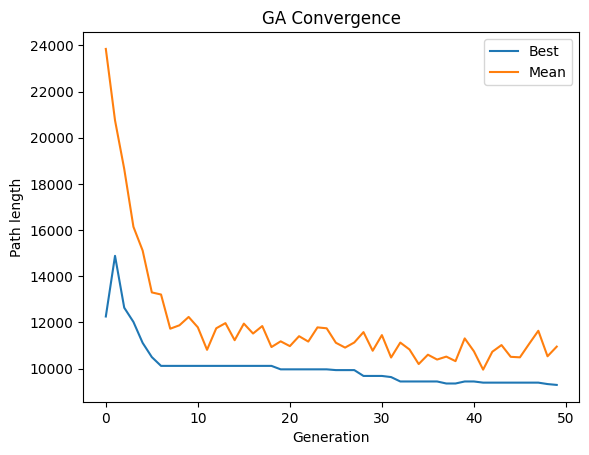

In [17]:
plt.plot(result.best_per_gen, label="Best")
plt.plot(result.mean_per_gen, label="Mean")
plt.xlabel("Generation")
plt.ylabel("Path length")
plt.title("GA Convergence")
plt.legend()
plt.show()

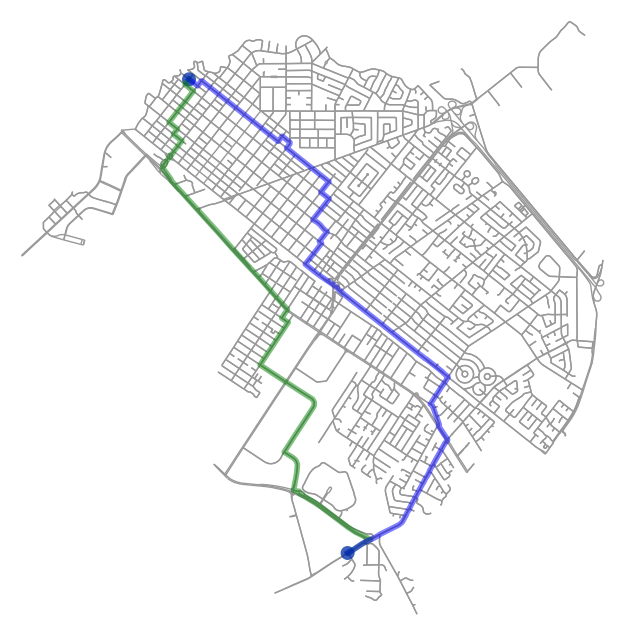

In [18]:
fig, ax = ox.plot_graph_routes(
    G_sub, [dijkstra_path, full_path],
    route_colors=['green', 'blue'],
    route_linewidth=3,
    node_size=0,
    bgcolor='white'
)

## Create GIF

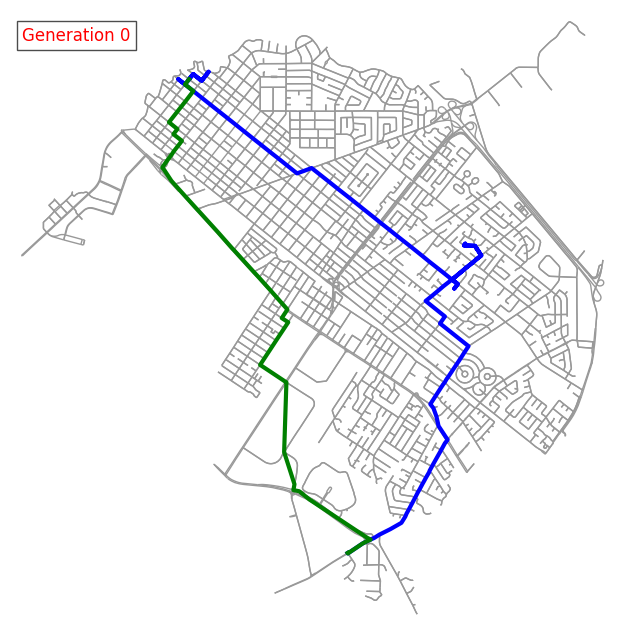

In [ ]:
fig, ax = ox.plot_graph(G_sub, show=False, close=False, node_size=0, bgcolor="white")

lines = []
text_label = None

def update(gen):
    global lines, text_label
    # Remove previous GA path lines
    for line in lines:
        line.remove()
    lines.clear()

    # Remove previous text
    if text_label:
        text_label.remove()

    # Plot GA best path (blue)
    ga_path = result.best_paths_per_gen[gen]
    xs = [G_sub.nodes[n]['x'] for n in ga_path]
    ys = [G_sub.nodes[n]['y'] for n in ga_path]
    line, = ax.plot(xs, ys, color='blue', linewidth=3, label='GA')
    lines.append(line)

    # Plot Dijkstra path (green) only once
    if gen == 0:
        dxs = [G_sub.nodes[n]['x'] for n in dijkstra_path]
        dys = [G_sub.nodes[n]['y'] for n in dijkstra_path]
        d_line, = ax.plot(dxs, dys, color='green', linewidth=3, label='Dijkstra')
        lines.append(d_line)

    # Add generation text
    text_label = ax.text(0.02, 0.95, f"Generation {gen}", transform=ax.transAxes,
                         fontsize=12, color='red', bbox=dict(facecolor='white', alpha=0.7))

    return lines + [text_label]

ani = animation.FuncAnimation(fig, update, frames=range(MAX_GEN), interval=500)
ani.save("ga_route_evolution_with_dijkstra.gif", writer='pillow')


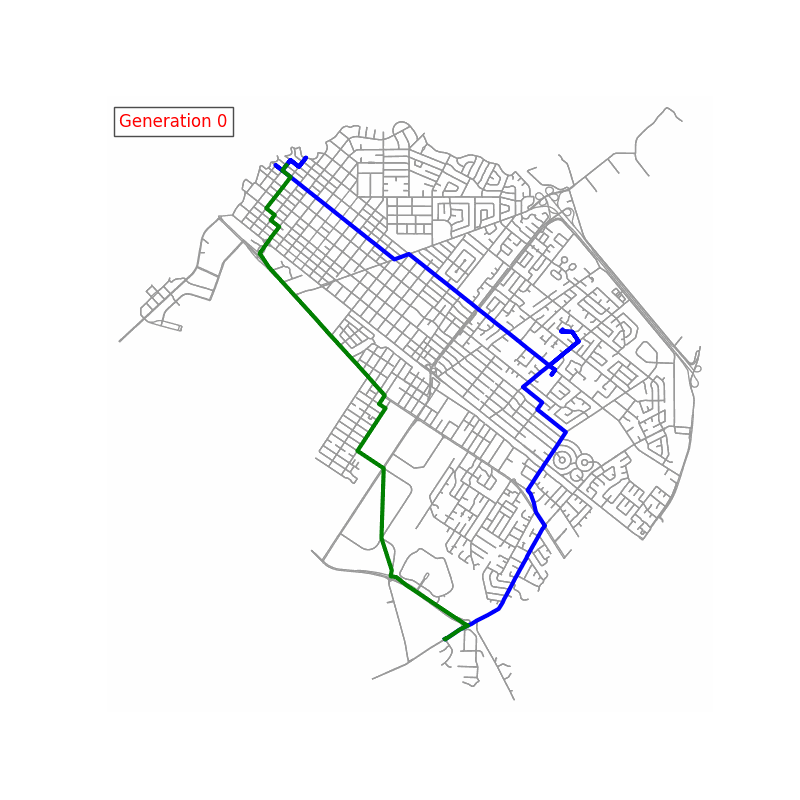

In [23]:
from IPython.display import Image, display
display(Image(filename="ga_route_evolution_with_dijkstra.gif"))